# Music Recomendations

In this project you will make an unsupervised system for music recommendations based on a song.

All of the data given to you is from Spotify. For definitions of some of the columns see https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features. The dataset has been partially processed to remove very unusual artists.

You will need to go through the entire machine learning process but for unsupervised learning (including big picture, exploration, ...). You will *not* split off a training and testing set. Also, you will not use cross-validation (see an example in a class notebook on how to convince `GridSearchCV` to not use CV). The ultimate goal is to be able to find which 'group' an audio track (which can be music, audio books, or other recordings) belongs to. We also want to make sure that none of the clusters are too small (so that if we ask for a related song, there is a significant amount of variability in the song that we get).

To help with making good clusters, you should form clusters for the artists and then integrate that information into each track's data. As with all preprocessing, you should try with and without this step (along with different clusterings of artists).


## Notes

### Artists Feature

The feature `artists` is actually a series of Python lists. To use them is a bit hard, but here are a few examples:
  * Get the length of the list for each row:  
    `data.artists.str.len()`
  * Get the first element of the list for each row:  
    `data.artists.apply(lambda artists:artists[0])`
  * Get the second element of the list for each row, or None if there is only one:   
    `data.artists.apply(lambda artists:artists[1] if len(artists) > 1 else None)`
  * To transform each artist in the list based on a dictionary named `trans` that has keys that are artists:  
    `data.artists.apply(lambda artists:(trans[artist] for artist in artists))`
  * To get the most common value from each list (once converted into something like numbers):  
    `data.artists.apply(statistics.mode)`
  * To make the list into multiple columns (filled with `None` for rows with fewer than max artists):  
    `pd.DataFrame({f'artists_{i}':data.artists.apply(lambda artists:artists[i] if len(artists) > i else None) for i in range(data.artists.str.len().max())})`

Also, other methods like `explode()` may be useful.


### Scoring

To be able to evaluate our model, we will need to use a custom scorer that can be used with `GridSearchCV` and `RandomSearchCV` that prefers clusters that contain pairs used by people in their personal playlists. This playlist data is in the `pairs` data. **This dataset must only be used for scoring.** Additionally, the scorer greatly penalizes having clusters that have less than 200 songs.

An example of using it is like:

```python
GridSearchCV(..., scoring=MusicScorer(data, pairs), ...)
```

where `data` and `pairs` are the full dataset and the pairs dataset from `load_data()`.


### Manual Testing

The function `recommendations()` can be used to perform manual testing. It can be called like:

```python
recommendations(data, clusters, ["50woGYhAqV3KXvO1LG4zLg", "6pmuu4qSz2WrtGkBjUfyuz", "3dmqIB2Qxe2XZobw9gXxJ6"])
```

where `data` is a `DataFrame` of all of the tracks (minimally the track ids) and `clusters` is a sequence of cluster numbers that line up with `data`.

In [20]:
import ast

import numpy as np
import scipy.sparse
import pandas as pd
#from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import set_config
set_config(display='diagram')



In [21]:
#%matplotlib widget

In [22]:
def load_data():
    """
    Returns the track data, the artist data, and which pairs of tracks show up
    together in playlists. The pairs dataset is extremely large but used as a
    sparse matrix. It cannot be directly used.
    """
    data = pd.read_csv('data.csv', converters={'artists':ast.literal_eval})
    artists = pd.read_csv('artists.csv')
    tracks = np.unique(data.id)
    pairs = pd.DataFrame.sparse.from_spmatrix(scipy.sparse.load_npz('track_pairs.npz'), index=tracks, columns=tracks)
    return data, artists, pairs


def music_score(data, clusters, pairs):
    """
    Scores a set of clusters based on the track data, the clusters they are assigned to,
    and the pairs data.
    """
    summation = 0
    n_clusters = max(clusters)
    #print(n_clusters)
    for i in range(n_clusters):
        if (clusters == i):
            tracks = data.id[clusters]
            sub = pairs.loc[tracks, tracks]
            denominator = len(tracks)
            if denominator < 200:
                denominator = (200*200*200*200)/(denominator*denominator*denominator)
            summation += sum(sub.values) / denominator
    return summation / n_clusters


class MusicScorer:
    """
    This is the actual scorer 'function' to use with `GridSearchCV`.
    It is used like:

    GridSearchCV(..., scoring=MusicScorer(data, pairs), ...)

    where `data` and `pairs` are the full dataset and the pairs
    dataset from `load_data()`.
    """

    def __init__(self, data, pairs):
        self.data = data
        self.pairs = pairs

    def __call__(self, estimator, X, y=None):
        # Get the cluster labels
        if hasattr(estimator, 'labels_'):
            labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            labels = estimator.predict(X)
        else:
            labels = estimator.fit_predict(X)

        # Compute the score
        return music_score(self.data, labels, self.pairs)


def recommendations(all_tracks, clusters, tracks, recommendations_per=5):
    """
    Given the complete data set (`all_tracks` is a DataFrame of track data or is
    a series/array of track ids) along with the `clusters` they belong to (a
    series/array of cluster numbers), lookup the given tracks (by their ids only),
    and return the number of recommendations per each of those tracks.

    If this is given a single track (as a string), this will return a single set
    of rows from `all_tracks`. If given a list of tracks (as a list of strings),
    this will return a list of sets of rows from `all_tracks`. The number of rows
    in each set is based on recommendations_per.
    """
    # force types
    full_data = len(all_tracks.shape) == 2
    all_tracks = pd.DataFrame(all_tracks) if full_data else pd.Series(all_tracks)
    all_tracks = all_tracks.reset_index(drop=True)
    clusters = pd.Series(clusters).reset_index(drop=True)
    single = isinstance(tracks, str)
    if single: tracks = [tracks]

    # get each track's cluster
    matches = all_tracks.id.isin(tracks) if full_data else all_tracks.isin(tracks)
    cluster_nums = clusters[matches]

    # sample from each cluster
    if single:
        return all_tracks.loc[clusters[clusters == cluster_nums.iloc[0]].sample(recommendations_per).index]
    return [all_tracks.loc[clusters[clusters == cluster].sample(recommendations_per).index] for cluster in cluster_nums]


# Frame the Problem and Look at the Big Picture 
1. Define the objective in business terms. 
    The objective is to make a machine learning model that will give music recommendations based on a song. 
2. How will your solution be used? 
    The solution will be used by users of spotify to get song recommendations based on the songs that they are listening to. 
3. What are the current solutions/workarounds (if any)? 
    Apple music uses a similar model to give recommendations.
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    This problem is an unsupervised, offline clustering problem.
5. How should performance be measured? Is the performance measure aligned with the business objective? 
    The performance will be measured using the custom scorer called MusicScorer() using the pairs dataset.
6. What would be the minimum performance needed to reach the business objective?
    # Each cluster must have more than 200 songs.
7. What are comparable problems? Can you reuse experience or tools? 
    # A comparable problem would be clustering handwritten digets. We could reuse some code from that document with some modifications.
8. Is human expertise available? 
    Human expertise is not availible.
9. How would you solve the problem manually? 
    Recommend popular songs in the same genre. 
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible. 
    - The recommended song must be on Spotify.
    # Add more here

# Get the Data 
1. List the data you need and how much you need 
    The data needed is songs and artists from Spotify, including their names, artist, genre, etc.
2. Find and document where you can get that data 
    Document was given to us by the client. It was taken from the Spotify API.
3. Get access authorizations 
    Permission recieved by the client.
4. Create a workspace (with enough storage space) 
    This notebook and repository on github.
5. Get the data
    Data was recieved by the client.
6. Convert the data to a format you can easily manipulate (without changing the data itself) 
    Data was formatted into 3 pandas dataframes.
7. Ensure sensitive information is deleted or protected (e.g. anonymized)
    There is no sensitive information that needs to be protected or anonymized.
8. Check the size and type of data (time series, geographical, ...) 
    The data dataframe has 61013 data points and 18 different features:
    
        id: object 
        name: object 
        artists: object 
        year: int64  
        duration_ms: int64  
        explicit: int64  
        popularity: int64  
        key: int64  
        mode: int64  
        tempo: float64
        loudness: float64
        acousticness: float64
        danceability: float64
        energy: float64
        instrumentalness: float64
        liveness: float64
        speechiness: float64
        valence: float64
        
    The artists dataframe has 6702 data points and 12 features:

        artist: object 
        count: int64  
        popularity: float64
        tempo: float64
        loudness: float64
        acousticness: float64
        danceability: float64
        energy: float64
        instrumentalness: float64
        liveness: float64
        speechiness: float64
        valence: float64
        
9. Sample a test set, put it aside, and never look at it (no data snooping!) 
    This is not applicable to unsupervised learning.

In [23]:
data, artists, pairs = load_data()

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61013 entries, 0 to 61012
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                61013 non-null  object 
 1   name              61013 non-null  object 
 2   artists           61013 non-null  object 
 3   year              61013 non-null  int64  
 4   duration_ms       61013 non-null  int64  
 5   explicit          61013 non-null  int64  
 6   popularity        61013 non-null  int64  
 7   key               61013 non-null  int64  
 8   mode              61013 non-null  int64  
 9   tempo             61013 non-null  float64
 10  loudness          61013 non-null  float64
 11  acousticness      61013 non-null  float64
 12  danceability      61013 non-null  float64
 13  energy            61013 non-null  float64
 14  instrumentalness  61013 non-null  float64
 15  liveness          61013 non-null  float64
 16  speechiness       61013 non-null  float6

In [25]:
data.head()

,id,name,artists,year,duration_ms,explicit,popularity,key,mode,tempo,loudness,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,3eMrYc092k7SIJfWJ7oasR,Weather Bird,"[Louis Armstrong, Earl Hines]",1923,161933,0,42,8,1,104.606,-12.386,0.984,0.831,0.2620,0.912000,0.204,0.0942,0.901
1,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,[Bessie Smith],1923,177133,0,42,4,1,89.822,-12.033,0.996,0.614,0.0423,0.002930,0.183,0.0535,0.211
2,2AZgaYZSwUosJD71J2N2Zo,'Tain't Nobody's Bizness If I Do,[Bessie Smith],1923,206600,0,29,3,0,80.468,-16.474,0.996,0.537,0.0443,0.000265,0.152,0.0343,0.137
3,7lRFR5GJCxK87ZbVMtQSeS,Ain't Misbehavin',[Louis Armstrong],1923,192600,0,32,8,1,125.734,-9.879,0.976,0.665,0.2540,0.002170,0.644,0.1080,0.503
4,0V1iYWPXCBTaB6dhbiprGF,Send Me to the 'Lectric Chair,[Bessie Smith],1923,201480,0,26,3,1,87.571,-7.788,0.986,0.771,0.0905,0.000141,0.152,0.0613,0.601


In [26]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            6702 non-null   object 
 1   count             6702 non-null   int64  
 2   popularity        6702 non-null   float64
 3   tempo             6702 non-null   float64
 4   loudness          6702 non-null   float64
 5   acousticness      6702 non-null   float64
 6   danceability      6702 non-null   float64
 7   energy            6702 non-null   float64
 8   instrumentalness  6702 non-null   float64
 9   liveness          6702 non-null   float64
 10  speechiness       6702 non-null   float64
 11  valence           6702 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 628.4+ KB


In [27]:
artists.head()

,artist,count,popularity,tempo,loudness,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,"""Cats"" 1983 Broadway Cast",26,30.576923,103.044154,-10.690000,0.862538,0.441731,0.406808,0.081158,0.315215,0.176212,0.268865
1,"""Fiddler On The Roof” Motion Picture Chorus",7,34.857143,77.375857,-15.230714,0.856571,0.348286,0.286571,0.024593,0.325786,0.118514,0.354857
2,"""Fiddler On The Roof” Motion Picture Orchestra",27,34.851852,88.667630,-15.639370,0.884926,0.425074,0.245770,0.073587,0.275481,0.123200,0.372030
3,"""Joseph And The Amazing Technicolor Dreamcoat""...",36,32.777778,118.648944,-18.266389,0.609556,0.487278,0.309906,0.004696,0.274767,0.098022,0.441556
4,"""Weird Al"" Yankovic",122,34.229508,133.031180,-9.768705,0.173145,0.662787,0.695393,0.000050,0.161102,0.084536,0.751344


In [28]:
(data.artists.str.len() < 10).value_counts()

True     60999
False       14
Name: artists, dtype: int64

In [29]:
data[data.artists.str.len() > 10]
# There are some songs that have more than 10 artists. 

,id,name,artists,year,duration_ms,explicit,popularity,key,mode,tempo,loudness,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
1787,7uv1H2DoWiGnxTWMV6B5qV,Are You Havin' Any Fun?,"[Tony Bennett, Count Basie, Benny Powell, Ralp...",1959,163747,0,41,0,1,138.135,-8.474,0.7320,0.514,0.499,0.000000,0.1770,0.0840,0.719
6486,5KMWwtJv3Ll2ROZfMerQs0,Same Old Train,"[Marty Stuart, Earl Scruggs, Clint Black, Joe ...",1998,361093,0,55,7,1,107.546,-12.646,0.0942,0.352,0.601,0.010500,0.1170,0.0323,0.370
6540,3nKLfeoq3YedJIZqvRW3Qz,I Don't Need Your Rockin' Chair - Version w/sp...,"[Mark Chesnutt, George Jones, Vince Gill, Patt...",1999,168640,0,62,0,1,93.865,-10.010,0.1520,0.680,0.589,0.000000,0.3780,0.0247,0.696
6791,0tzixmHNQfE6S6SirSToxW,El Ultimo Adiós - Varios Artistas Version,"[Ricky Martin, Alejandro Sanz, Thalia, Juan Lu...",2001,237467,0,68,1,1,77.986,-7.818,0.6410,0.276,0.572,0.000000,0.2000,0.0377,0.285
9326,7G5L3XC5LMcReydpXlxHov,With Plenty Of Money And You,"[Tony Bennett, Count Basie, Marshall Royal, Ra...",1959,92880,0,28,5,0,131.525,-7.745,0.7120,0.489,0.715,0.000002,0.2490,0.1480,0.621
16011,4IhBcazBOrGm8CHegL1uiT,Jeepers Creepers,"[Tony Bennett, Count Basie, Benny Powell, Ralp...",1959,127973,0,25,0,1,78.572,-9.609,0.6170,0.545,0.451,0.000000,0.2940,0.0447,0.848
27845,2NYYUTe0vuU5Tq4smECz71,Welcome To My Hood - Remix,"[DJ Khaled, Ludacris, Busta Rhymes, Twista, T-...",2011,430733,1,53,7,1,140.077,-4.203,0.0221,0.585,0.815,0.000000,0.1400,0.2280,0.541
28774,2Z7e4ZqWJiF59fUwOPdjFa,Anything Goes,"[Tony Bennett, Count Basie, Ralph Sharon, Sonn...",1959,139600,0,18,0,1,138.216,-7.766,0.7560,0.467,0.562,0.000000,0.0464,0.0511,0.789
28784,0vSub3PX06qDJj51isuAGC,Chicago,"[Tony Bennett, Count Basie, Snookey Young, Son...",1959,126587,0,20,2,0,115.678,-7.091,0.7780,0.460,0.567,0.000000,0.1240,0.0737,0.678
39903,6qsIvR5nOciPp7ci0M3NNj,Will The Circle Be Unbroken - Live,"[Susan Tedeschi, Keb' Mo', Brantley Gilbert, D...",2014,538760,0,52,7,1,128.001,-7.833,0.2000,0.303,0.741,0.000069,0.9090,0.0461,0.312


In [30]:
data_artists = pd.DataFrame({f'artists_{i}':data.artists.apply(lambda artists:artists[i] if len(artists) > i else None) for i in range(data.artists.str.len().max())})
data_artists

,artists_0,artists_1,artists_2,artists_3,artists_4,artists_5,artists_6,artists_7,artists_8,artists_9,...,artists_20,artists_21,artists_22,artists_23,artists_24,artists_25,artists_26,artists_27,artists_28,artists_29
0,Louis Armstrong,Earl Hines,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Bessie Smith,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Bessie Smith,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Louis Armstrong,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Bessie Smith,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61008,"Tyler, The Creator",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
61009,Jhené Aiko,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
61010,Kodak Black,Future,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
61011,Wiz Khalifa,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [31]:
new_data = data.join(data_artists)
new_data

,id,name,artists,year,duration_ms,explicit,popularity,key,mode,tempo,...,artists_20,artists_21,artists_22,artists_23,artists_24,artists_25,artists_26,artists_27,artists_28,artists_29
0,3eMrYc092k7SIJfWJ7oasR,Weather Bird,"[Louis Armstrong, Earl Hines]",1923,161933,0,42,8,1,104.606,...,None,None,None,None,None,None,None,None,None,None
1,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,[Bessie Smith],1923,177133,0,42,4,1,89.822,...,None,None,None,None,None,None,None,None,None,None
2,2AZgaYZSwUosJD71J2N2Zo,'Tain't Nobody's Bizness If I Do,[Bessie Smith],1923,206600,0,29,3,0,80.468,...,None,None,None,None,None,None,None,None,None,None
3,7lRFR5GJCxK87ZbVMtQSeS,Ain't Misbehavin',[Louis Armstrong],1923,192600,0,32,8,1,125.734,...,None,None,None,None,None,None,None,None,None,None
4,0V1iYWPXCBTaB6dhbiprGF,Send Me to the 'Lectric Chair,[Bessie Smith],1923,201480,0,26,3,1,87.571,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61008,3R1Vu4Ws7UitwDxDHTol0P,"Enjoy Right Now, Today","[Tyler, The Creator]",2017,235400,0,57,1,1,162.126,...,None,None,None,None,None,None,None,None,None,None
61009,0PYmO55JPwEWgtyJbkN6mq,New Balance,[Jhené Aiko],2017,279453,1,55,4,0,74.305,...,None,None,None,None,None,None,None,None,None,None
61010,16dXg2YuFOxwDC3cTf5jde,Conscience (feat. Future),"[Kodak Black, Future]",2017,219754,1,54,1,1,159.972,...,None,None,None,None,None,None,None,None,None,None
61011,6HicBL9RxtWwNK7sS2AHHU,Phone Jumpin,[Wiz Khalifa],2017,247227,1,55,9,0,140.140,...,None,None,None,None,None,None,None,None,None,None


In [32]:
new_data['artists_0']

0           Louis Armstrong
1              Bessie Smith
2              Bessie Smith
3           Louis Armstrong
4              Bessie Smith
                ...        
61008    Tyler, The Creator
61009            Jhené Aiko
61010           Kodak Black
61011           Wiz Khalifa
61012       Hippie Sabotage
Name: artists_0, Length: 61013, dtype: object

# Explore the Data 
1. Copy the data for exploration, downsampling to a manageable size if necessary. 
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, 
bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); 
Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
3. For supervised learning tasks, identify the target attribute(s) 
    Not applicable in this task. (Unsupervised)
4. Visualize the data 
5. Study the correlations between attributes 
6. Study how you would solve the problem manually 
7. Identify the promising transformations you may want to apply 
8. Identify extra data that would be useful (go back to “Get the Data”) 
9. Document what you have learned 
    Done Above.

In [33]:
artists_copy = artists.copy() # X
data_copy = data.copy() # y


In [34]:
artists_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            6702 non-null   object 
 1   count             6702 non-null   int64  
 2   popularity        6702 non-null   float64
 3   tempo             6702 non-null   float64
 4   loudness          6702 non-null   float64
 5   acousticness      6702 non-null   float64
 6   danceability      6702 non-null   float64
 7   energy            6702 non-null   float64
 8   instrumentalness  6702 non-null   float64
 9   liveness          6702 non-null   float64
 10  speechiness       6702 non-null   float64
 11  valence           6702 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 628.4+ KB


All of the features except <mark>id, name, and artists</mark> are numerical features. <mark>id</mark> is a categorical feature that makes each song unique. <mark>name</mark> and <mark>artists</mark> are textual features that defines the song. By this analysis, using the <mark>OrdinalEncoder</mark> will use there to convert text into integer array. Also, there are multiple songs that can be written by the same artist. 

<AxesSubplot:>

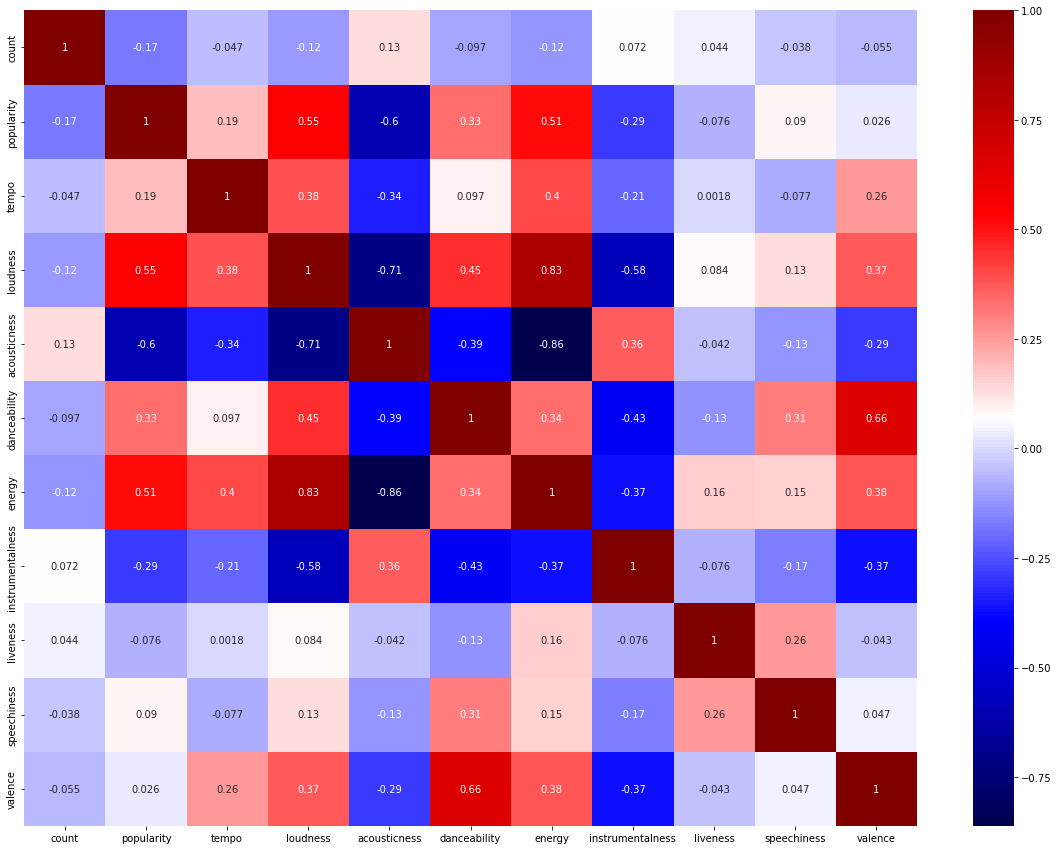

In [35]:
plt.figure(figsize=(20, 15))
sns.heatmap(artists_copy.corr(), cmap='seismic', annot=True)

Based on the heatmap, we can see that there are multiple features that have high positive correlations. 
High Positive Correlation
- energy and loudness
- year and popularity 
- valence and danceability



# Prepare the Data 
1. Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, 
median...) or drop rows/columns 
2. Feature selection (optional): Drop attributes that provide no useful information 
for the task 
3. Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, ...), 
Add promising transformations of features (log(𝑥𝑥), √𝑥𝑥, 𝑥𝑥2, ...); Aggregate features into promising new features 
4. Feature scaling: standardize or normalize features 

In [36]:
'''
The first pipeline is where it is converting textual feature into an array of integers
and standardizing all the features. Then, use PCA to reduce the input dimensions.
'''
preprocessor = Pipeline(steps=[
    ('ColumnTransformerArtistColumn', ColumnTransformer(transformers=[
        ('OrdinalEncoding', OrdinalEncoder(), ['artist'])  
    ])),
    ('Standard_scaler', StandardScaler()),
    
    ('PCA', PCA()),
])

In [37]:
preprocessor.fit(artists_copy)

Pipeline(steps=[('ColumnTransformerArtistColumn',
                 ColumnTransformer(transformers=[('OrdinalEncoding',
                                                  OrdinalEncoder(),
                                                  ['artist'])])),
                ('Standard_scaler', StandardScaler()), ('PCA', PCA())])

In [38]:
ks = range(20,100)
kmeans = []
for k in ks:
    clusterer_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('KMeans', KMeans(k))
    ]).fit(artists_copy)
    kmeans.append(clusterer_pipeline)

Text(0, 0.5, 'Inertia')

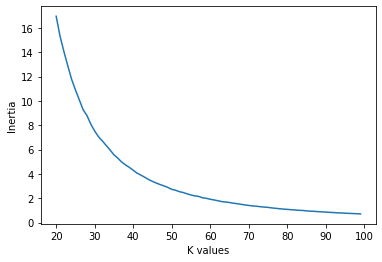

In [39]:
plt.figure()
inertias = [clusterer.named_steps.KMeans.inertia_ for clusterer in kmeans]
plt.plot(ks, inertias)
plt.xlabel('K values')
plt.ylabel('Inertia')

In [40]:
transformed = clusterer_pipeline.transform(artists_copy)
silhouettes = [silhouette_score(transformed, clusterer.predict(artists_copy)) for clusterer in kmeans]

In [41]:
silhouettes

[0.5227697338132441,
 0.5230931135171776,
 0.5225627076002051,
 0.522669177365671,
 0.5222667203617823,
 0.521880808655218,
 0.5209632382433156,
 0.5207790595027255,
 0.5215421176208028,
 0.5202248977761005,
 0.5200088069204898,
 0.5203151810516986,
 0.5187235292121217,
 0.519358534669312,
 0.518671799861204,
 0.5197492896428009,
 0.5187400860134922,
 0.5191519265032408,
 0.5188357177814316,
 0.5172978911220873,
 0.5175869653532161,
 0.5178649122911397,
 0.517972782243637,
 0.5168731910506889,
 0.5171583800959076,
 0.5172268692073644,
 0.516478180570416,
 0.5168208295751565,
 0.5163007754084442,
 0.5160432992219011,
 0.5162458765332194,
 0.5162928043024744,
 0.5155061183774522,
 0.5153048995481403,
 0.5152424669609946,
 0.5155952262174718,
 0.5152253625805963,
 0.5153331112137756,
 0.5150558992100965,
 0.514717679800141,
 0.5147486639103876,
 0.51388974565706,
 0.5150055183900777,
 0.5140518932662236,
 0.5139277147788124,
 0.5138935592212867,
 0.5137957766239019,
 0.5140555511904396,
 

In [42]:
class ArtistTransformer(BaseEstimator, TransformerMixin):
    """
    This transformer is used to transform the column of artist names (a list of
    strings) to a one-hot-encoded-esque set of columns. This is done by applying
    a clusterer (which can be entire pipeline that ends with a clusterer) to the
    given artist data. The clusterer can be tweaked with the parameter grid that
    tweaks whatever pipeline/column transformer this is part of.

    Make sure to use a ColumnTransformer to only send one column to this
    transformer and that column contains a list of artist names. It outputs a
    sequence of features that are all 0's and 1's, one feature for each cluster
    number. The parameter grid can use things like ...__clusterer__... to access
    the clusterer's (which is likely a pipeline) parameters.
    """
    def __init__(self, clusterer, artist_data):
        self.clusterer = clusterer
        self.artist_data = artist_data

    def fit(self, X, y=None):
        self.labels_ = self.clusterer.fit_predict(self.artist_data)
        self.trans_ = pd.Series(self.labels_, index=self.artist_data.artist)
        X = X.apply(lambda artists:[self.trans_[artist] for artist in artists])
        self.mlb_ = MultiLabelBinarizer().fit(X.iloc[:, 0])
        return self

    def transform(self, X):
        X = X.apply(lambda artists:[self.trans_[artist] for artist in artists])
        return self.mlb_.transform(X.iloc[:, 0])

In [43]:
for kmean in kmeans:
    final_pipeline = Pipeline(steps=[
        ('ColumnTransformerForClass', ColumnTransformer(transformers=[
            ('ArtistTransformer', ArtistTransformer(kmean, data_copy.artists), [])
        ],remainder='passthrough'))
    ])

# Fine-Tune the System 
1. Fine-tune the hyperparameters using cross-validation. Treat your data 
transformation choices as hyperparameters, especially when you are not sure 
about them. Unless there are very few hyperparameter values to explore, prefer 
random search over grid search. If training is very long, you may prefer a Bayesian 
optimization approach. 
2. Try Ensemble methods. Combining your best models will often perform better 
than running them individually. 
3. Once you are confident about your final model, measure its performance on the 
test set to estimate the generalization error. 

In [44]:

#cross_val_score(final_pipeline, data_copy, pairs_copy).mean()
final_pipeline.fit(artists_copy)
scores = music_score(data, ks, pairs)
scores

0.0

In [46]:
final_pipeline.get_params().keys() # Seeing the param keys of the pipeline. 

dict_keys(['memory', 'steps', 'verbose', 'ColumnTransformerForClass', 'ColumnTransformerForClass__n_jobs', 'ColumnTransformerForClass__remainder', 'ColumnTransformerForClass__sparse_threshold', 'ColumnTransformerForClass__transformer_weights', 'ColumnTransformerForClass__transformers', 'ColumnTransformerForClass__verbose', 'ColumnTransformerForClass__verbose_feature_names_out', 'ColumnTransformerForClass__ArtistTransformer', 'ColumnTransformerForClass__ArtistTransformer__artist_data', 'ColumnTransformerForClass__ArtistTransformer__clusterer__memory', 'ColumnTransformerForClass__ArtistTransformer__clusterer__steps', 'ColumnTransformerForClass__ArtistTransformer__clusterer__verbose', 'ColumnTransformerForClass__ArtistTransformer__clusterer__preprocessor', 'ColumnTransformerForClass__ArtistTransformer__clusterer__KMeans', 'ColumnTransformerForClass__ArtistTransformer__clusterer__preprocessor__memory', 'ColumnTransformerForClass__ArtistTransformer__clusterer__preprocessor__steps', 'ColumnT

In [47]:
param_grid = {
    'kmeans__n_clusters': range(10, 101)
}
search = GridSearchCV(final_pipeline, param_grid, cv=[(slice(None), slice(None))], 
        scoring=MusicScorer(data, pairs), n_jobs=-1, verbose=3)

# Testing 


In [ ]:
recommendations(data, ks, ["50woGYhAqV3KXvO1LG4zLg", "6pmuu4qSz2WrtGkBjUfyuz", "3dmqIB2Qxe2XZobw9gXxJ6"])

[]